In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import re

def filter_noise(data, window_size):
    """Фильтрация шума с использованием скользящего среднего"""
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def calculate_weight(data1, data2):
    """Вычисление веса путем усреднения данных с двух тензомодулей"""
    return np.mean(np.concatenate((data1, data2)))

# Пример данных с тензомодулей
data1 = np.array([24.13, 20.68, 20.68, 27.98])  # ScaleID 1
data2 = np.array([25.41, 25.41, 22.45])         # ScaleID 2

# Фильтрация шума
data1_filtered = filter_noise(data1, window_size=2)
data2_filtered = filter_noise(data2, window_size=2)

# Вычисление веса
weight = calculate_weight(data1_filtered, data2_filtered)

print(f'Вес лопатки: {weight} г')

Вес лопатки: 23.351 г


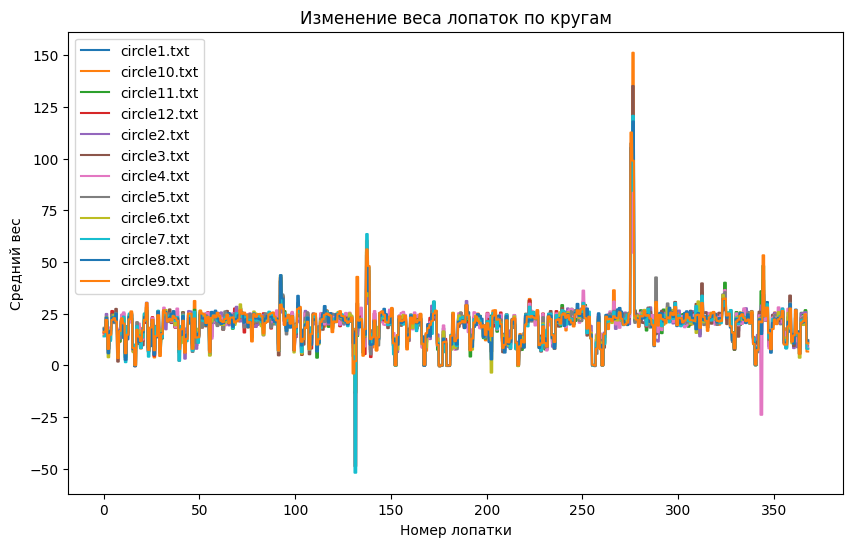

In [35]:
# Выводим на график значения весов по каждому кругу

def process_file(filename):
    """Считывание и обработка данных из файла"""
    df = pd.read_csv(filename, header=None)
    df = df[df[1].isin([1, 2])]
    df['weight'] = df.groupby(df[5].astype(int))[4].transform('mean')
    weights = df[[5, 'weight']].drop_duplicates()
    return weights

files = glob.glob('circle*.txt')

plt.figure(figsize=(10, 6))

for file in files:
    weights = process_file(file)
    plt.plot(weights[5], weights['weight'], label=file)

plt.xlabel('Номер лопатки')
plt.ylabel('Средний вес')
plt.title('Изменение веса лопаток по кругам')
plt.legend()
plt.show()

In [12]:
def detect_outliers(data):
    """Обнаружение выбросов с использованием межквартильного размаха"""
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR
    outliers = data[(data < Q1 - outlier_step) | (data > Q3 + outlier_step)]
    return outliers

for file in files:
    weights = process_file(file)
    outliers = detect_outliers(weights['weight'])
    print(f'Выбросы в файле {file}:', outliers)

Выбросы в файле circle1.txt: Series([], Name: weight, dtype: float64)
Выбросы в файле circle10.txt: 226      0.158571
228      0.158571
230      0.158571
232      0.158571
234      0.158571
          ...    
4869    41.167143
4871    41.167143
4873    41.167143
4875    41.167143
4877    41.167143
Name: weight, Length: 133, dtype: float64
Выбросы в файле circle11.txt: 227     -0.071429
229     -0.071429
231     -0.071429
233     -0.071429
235     -0.071429
          ...    
4867    48.134286
4869    48.134286
4871    48.134286
4873    48.134286
4875    48.134286
Name: weight, Length: 141, dtype: float64
Выбросы в файле circle12.txt: 1301    42.422857
1303    42.422857
1305    42.422857
1307    42.422857
1309    42.422857
1311    42.422857
1313    42.422857
1854   -48.925714
1856   -48.925714
1858   -48.925714
1860   -48.925714
1862   -48.925714
1864   -48.925714
1866   -48.925714
1938    53.362857
1940    53.362857
1942    53.362857
1944    53.362857
1946    53.362857
1948    53.362857


In [34]:
# Записываем выбросы в файл простым копированием строки из файлов circle1.txt, circle2.txt, ...
for file in files:
    df = pd.read_csv(file, header=None)
    weights = df[df[1].isin([1, 2])].copy()
    weights.loc[:, 'weight'] = weights.groupby(weights[5].astype(int))[4].transform('mean')
    outliers = detect_outliers(weights['weight'])
    outliers_df = df.loc[outliers.index]
    with open('outliers.txt', 'a') as f:
        f.write(f'Выбросы в файле {file}:\n')
        outliers_df.to_csv(f, header=False, index=False)

In [33]:
# Запись в файл значений весов для каждого круга, и в конце средние значения по всем кругам (кроме первого и последнего)
def process_file(filename):
    """Считывание и обработка данных из файла"""
    df = pd.read_csv(filename, header=None)
    df = df[df[1].isin([1, 2])]
    df['weight'] = df.groupby(df[5].astype(int))[4].transform('mean')
    weights = df[[5, 'weight']].drop_duplicates()
    return weights

files = glob.glob('circle*.txt')

mean_df = pd.DataFrame()  # для хранения средних значений

for i, file in enumerate(files, start=1):
    weights = process_file(file)
    weights[5] = weights[5].astype(int)  # округление до целого
    weights = weights.groupby(5)['weight'].mean().reset_index()  # группировка по энкодеру и вычисление среднего веса
    with open('weights.txt', 'a') as f:
        f.write(f'==========Круг {i}==========\n')
        for _, row in weights.iterrows():
            f.write(f'{int(row[5])}: {round(row["weight"], 2)}\n')  # запись номера энкодера и веса
    if i > 1 and i < len(files):  # исключение первого и последнего круга
        mean_df = pd.concat([mean_df, weights.set_index(5)], axis=1)

# Вычисление средних значений
mean_df = mean_df.mean(axis=1)

# Запись средних значений в файл
with open('weights.txt', 'a') as f:
    f.write('\nСредние значения:\n')
    mean_df.to_csv(f, header=False)

In [24]:
# Парсинг файла с выбросами (с простым копированием) и приведение в божеский вид

def parse_file(file_name):
    with open(file_name, 'r') as file:
        data = file.read()

    circles = re.findall(r'circle(\d+).txt:(.*?)Выбросы', data, re.DOTALL)
    circles.append(re.findall(r'circle(\d+).txt:(.*)', data, re.DOTALL)[-1])  # добавляем последний круг

    for circle in circles:
        circle_number = circle[0]
        outliers = re.findall(r'(\d+),\d+,\d+.\d+,A,(-?\d+.\d+),(\d+.\d+)', circle[1])
        outliers = [(float(outlier[1]), float(outlier[2])) for outlier in outliers]

        print(f'Круг {circle_number}:')
        if not outliers:
            print('нет выбросов')
        else:
            current_encoder = int(outliers[0][1])
            current_outliers = [outliers[0][0]]
            current_encoders = [outliers[0][1]]
            for outlier in outliers[1:]:
                if int(outlier[1]) == current_encoder:
                    current_outliers.append(outlier[0])
                    current_encoders.append(outlier[1])
                else:
                    print(f'выбросы {current_outliers} на энкодерах {current_encoders}')
                    current_encoder = int(outlier[1])
                    current_outliers = [outlier[0]]
                    current_encoders = [outlier[1]]
            print(f'выбросы {current_outliers} на энкодерах {current_encoders}')

parse_file('outliers.txt')

Круг 1:
нет выбросов
Круг 10:
выбросы [0.31, 0.22, 0.31, 0.22, 0.45, -0.85, 0.45] на энкодерах [16.1, 16.2, 16.3, 16.5, 16.6, 16.8, 16.9]
выбросы [-0.72, 28.26, 85.22, 70.24, 85.22, 70.24, 83.6] на энкодерах [137.0, 137.1, 137.3, 137.4, 137.6, 137.7, 137.9]
выбросы [63.09, 83.6, 63.09, 20.03, 29.22, 20.03, 29.22] на энкодерах [138.0, 138.2, 138.3, 138.4, 138.6, 138.7, 138.9]
выбросы [0.22, 0.31, 0.22, 0.31, -1.39, 0.31, -1.39] на энкодерах [152.0, 152.2, 152.3, 152.4, 152.6, 152.7, 152.9]
выбросы [-0.31, 0.59, -0.31, 0.59, -0.45, 0.03, -0.45] на энкодерах [167.0, 167.2, 167.3, 167.4, 167.6, 167.7, 167.8]
выбросы [0.45, -0.99, 0.45, -0.99, 0.31, -1.12, 0.31] на энкодерах [175.1, 175.2, 175.3, 175.5, 175.6, 175.8, 175.9]
выбросы [-1.26, 0.31, -1.26, 0.31, -0.18, 0.72, -0.18] на энкодерах [176.1, 176.2, 176.4, 176.5, 176.6, 176.8, 176.9]
выбросы [0.31, -0.45, 0.31, -1.12, 0.17, -1.12, 0.59] на энкодерах [179.0, 179.2, 179.3, 179.4, 179.6, 179.7, 179.9]
выбросы [-0.18, 0.59, -0.18, 0.45, -